Image dimensions are (2, 1024, 1024)


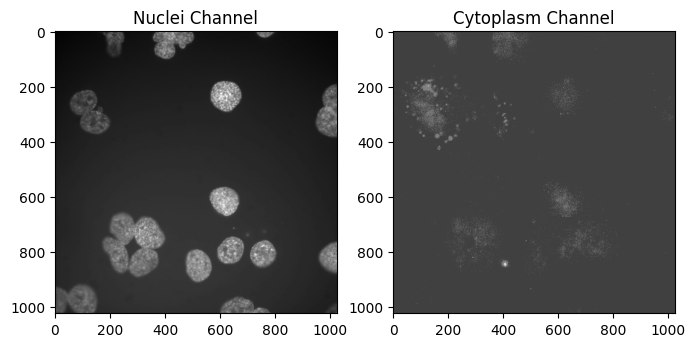

In [1]:
    import os
    import skimage
    import skimage.io
    import numpy as np
    import matplotlib.pyplot as plt
    import skimage.filters
    from pathlib import Path
    import scipy.ndimage as ndi
    import pandas as pd
    from tqdm import tqdm
    from scipy import ndimage

img = skimage.io.imread('C:/Users/LocalUser/Desktop/Muitos_MN/SCC9/SCC9_2H_B.lif_11.tif')
print('Image dimensions are', img.shape)
image = skimage.img_as_ubyte(img)

nuclei = image[0,:,:]
cytoplasm = image[1,:,:]

fig, axs = plt.subplots(1, 2, figsize=(8, 8))
    
axs[0].imshow(nuclei, cmap='gray')
axs[0].set_title('Nuclei Channel');
axs[1].imshow(cytoplasm, cmap = 'gray')
axs[1].set_title('Cytoplasm Channel');

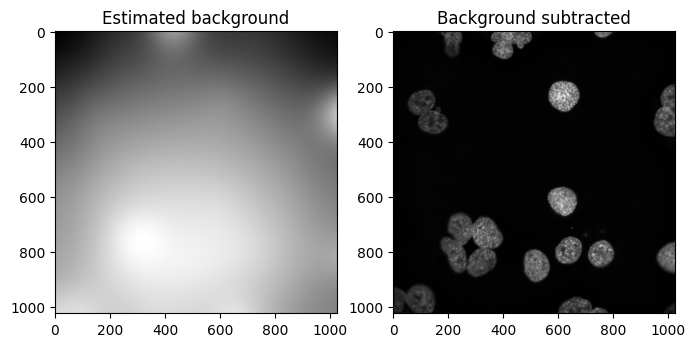

In [2]:
background = skimage.filters.rank.percentile(nuclei, p0=0.1, footprint=np.ones((100, 100), dtype=bool))
background = skimage.filters.gaussian(background, sigma=60, preserve_range=True)

image_bs = nuclei - background
image_bs = np.abs(image_bs) # remove negative values

fig, axs = plt.subplots(1, 2, figsize = (8,8))

axs[0].set_title('Estimated background')
axs[0].imshow(background, cmap='gray')
axs[1].set_title('Background subtracted')
axs[1].imshow(image_bs, cmap='gray');

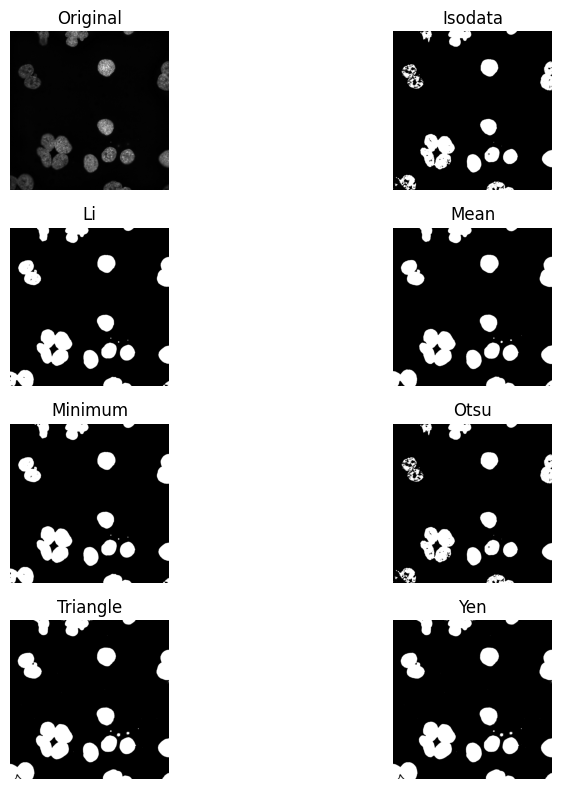

In [3]:
skimage.filters.try_all_threshold(image_bs, figsize=(10, 8), verbose=False);

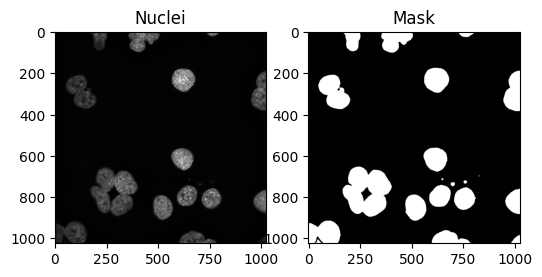

In [4]:
nuclei_mask = image_bs > skimage.filters.threshold_yen(image_bs)
nuclei_mask = skimage.morphology.binary_opening(nuclei_mask)

fig, axs = plt.subplots(1, 2, figsize = (6,6))

axs[0].set_title('Nuclei')
axs[0].imshow(image_bs, cmap='gray')
axs[1].set_title('Mask')
axs[1].imshow(nuclei_mask, cmap='gray');

In [ ]:
dist = ndimage.distance_transform_edt(nuclei_mask)
dist_g = skimage.filters.gaussian(dist, sigma=3)

coords = skimage.feature.peak_local_max(dist_g, exclude_border=False)

fig, axs = plt.subplots(1, 2, figsize=(6, 6))

axs[0].imshow(nuclei_mask, cmap='gray')
axs[0].set_title('Mask')
axs[1].imshow(dist, cmap='gray')
axs[1].scatter(coords[:, 1], coords[:, 0], s=2)
axs[1].set_title('Distance Transform with Local Maxima');

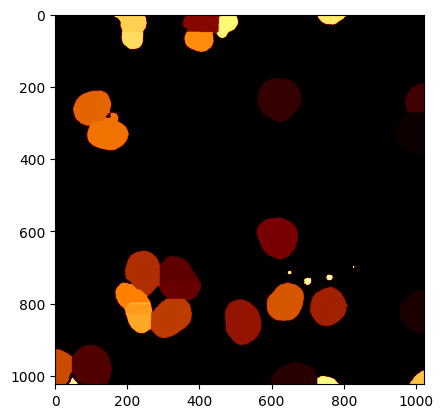

In [6]:
markers = np.zeros(nuclei_mask.shape, dtype='uint8')
for i in range(len(coords)):
    markers[coords[i, 0], coords[i, 1]] = i + 1

labels = skimage.segmentation.watershed(-dist, markers, mask=nuclei_mask)
nuclei_labels = labels

plt.imshow(nuclei_labels, cmap='afmhot')

In [7]:
my_regions = skimage.measure.regionprops_table(nuclei_labels, properties=('label','area'))
my_regions

{'label': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 'area': array([7.7870e+03, 6.4940e+03, 6.2160e+03, 1.1271e+04, 3.7130e+03,
        9.9580e+03, 5.7190e+03, 5.1250e+03, 1.0135e+04, 4.7740e+03,
        1.0082e+04, 8.4700e+03, 9.0200e+03, 9.7100e+03, 3.9730e+03,
        8.5360e+03, 7.8030e+03, 8.2590e+03, 4.1020e+03, 3.7950e+03,
        1.8960e+03, 3.0150e+03, 3.0100e+02, 1.0640e+03, 3.4520e+03,
        2.4870e+03, 1.7490e+03, 2.7520e+03, 1.0090e+03, 1.9400e+02,
        2.3600e+02, 3.1600e+02, 2.1500e+02, 7.6000e+01, 2.3000e+01,
        1.3000e+01, 9.0000e+00, 9.0000e+00])}

In [8]:
my_regions_df = pd.DataFrame(my_regions)
my_regions_df

,label,area
0,1,7787.0
1,2,6494.0
2,3,6216.0
3,4,11271.0
4,5,3713.0
5,6,9958.0
6,7,5719.0
7,8,5125.0
8,9,10135.0
9,10,4774.0


In [9]:
selected = my_regions['area'] > 2000
selected 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False])

In [10]:
my_regions['area'][selected]

array([ 7787.,  6494.,  6216., 11271.,  3713.,  9958.,  5719.,  5125.,
       10135.,  4774., 10082.,  8470.,  9020.,  9710.,  3973.,  8536.,
        7803.,  8259.,  4102.,  3795.,  3015.,  3452.,  2487.,  2752.])

In [11]:
results_small_removed = my_regions_df[my_regions_df['area'] > 2000]

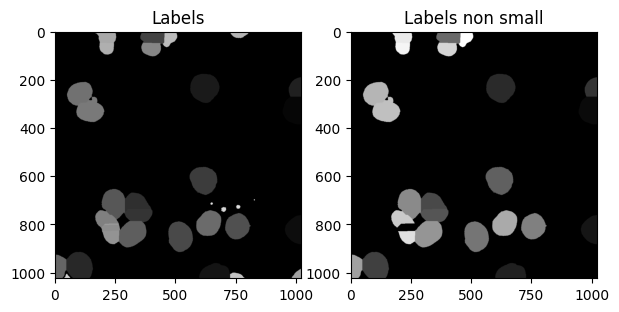

In [12]:
filtered_labels = np.isin(nuclei_labels, results_small_removed['label'])
filtered_labels_relabel = skimage.segmentation.relabel_sequential(filtered_labels * nuclei_labels)[0]

fig, axs = plt.subplots(1, 2, figsize=(7, 7))

axs[0].imshow(nuclei_labels, cmap = 'gray')
axs[0].set_title('Labels');
axs[1].imshow(filtered_labels_relabel, cmap='gray');
axs[1].set_title('Labels non small');

In [ ]:
from cellpose import io
from cellpose import models

io.logger_setup() # run this to get printing of progress
model = models.Cellpose(gpu=False, model_type='nuclei')

masks_pred, flows, styles, diams = model.eval(nuclei, diameter=60, channels=[0,0])

In [ ]:
plt.imshow(masks_pred, cmap='gray')

In [ ]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()
# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

In [ ]:
from stardist.plot import render_label
from csbdeep.utils import normalize

labels, _ = model.predict_instances(normalize(nuclei))
plt.imshow(render_label(labels, img=nuclei))

In [ ]:
from instanseg import InstanSeg
from instanseg.utils.utils import show_images

labeled_output = instanseg_brightfield.eval(image = nuclei,
                                            save_output = True,
                                            save_overlay=True,)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (8,8))

axs[0,0].set_title('Original Image')
axs[0,0].imshow(nuclei, cmap='gray')
axs[0,1].set_title('Distance Transform Watershed')
axs[0,1].imshow(nuclei_labels, cmap='gray')
axs[1,0].set_title('Cellpose Segmentation')
axs[1,0].imshow(masks_pred, cmap='gray');
axs[1,1].set_title('Stardist Segmentation 2D_versatile_fluo')
axs[1,1].imshow(labels, cmap='gray')